In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import math

In [2]:
our_color_palette ={"WT": "#F2C14E", "KO": "#F15BB5", "OE": "#368F8B"}
genotype_dict = {"dicer_KO": "KO", "dicer_overexpressed": "OE", "wild_type": "WT", "dicer_over_expressing": "OE"}

### Load co-occurrinng mutations

In [3]:
fname_WT =  '../../resources/run_workflow/results_cluster/wild_type/cooccurring_mutations.EB_space.csv'
fname_KO =  '../../resources/run_workflow/results_cluster/dicer_KO/cooccurring_mutations.EB_space.csv'
fname_OE =  '../../resources/run_workflow/results_cluster/dicer_overexpression/cooccurring_mutations.EB_space.csv'

df = pd.concat([pd.read_csv(fname_WT), 
                pd.read_csv(fname_OE), 
                pd.read_csv(fname_KO)])

df = df.rename(columns={"sample": "genotype", "patient": "replicate", "date": "passage"})

df['genotype'] = df["genotype"].apply(lambda x: genotype_dict[x])

In [4]:
df['window_range'] = df['start'].astype(str) + '-' + df['end'].astype(str)
df['haplotype_id_short'] = df['haplotype_id'].str.split('-').str[0]
df['identifier'] = df['genotype'] + '-' + df['replicate'] + '-' + df['passage'] + '-' + df['haplotype_id']

df = df[['identifier', 'genotype', 'replicate', 'passage', 'haplotype_id', 'window_range', 'ref', 'var', 'freq', 
         'position_EB_space', 'haplotype_id_short']]

# define a mutation id
df['mutation_id'] = df['position_EB_space'].astype(str) + '-' + df['var']

### Filter for mutations around around 7567 

In [5]:
identifiers_of_interest = df[df['position_EB_space'].isin(range(7555, 7570))]['identifier'].unique()
df_red = df[df['identifier'].isin(identifiers_of_interest)]

In [6]:
df_red = df_red[df_red['position_EB_space'].isin([7557, 7567, 7566])]
df_red = df_red[df_red['freq']>0.0001]

# only look at one window since the frequencies are very similar
df_red = df_red[df_red['window_range']=='7507-7587']

df_red['passage']= df_red['passage'].str.split('_').str[1].astype(int)

In [7]:
df_red_pivot = df_red.pivot_table(values=['freq'], 
                                    index=['genotype','replicate','passage','window_range','haplotype_id_short'], 
                                    columns='mutation_id', 
                                   )

In [8]:
def f_get_codon(row):
    parental_codon = 'TAT'
    codon = parental_codon
    codon_freq = 1.0

    existing_mutations_7566 = ['7566-A', '7566-C', '7566-G']
    existing_mutations_7567 = ['7567-C', '7567-G']
    
    for pos_7566 in existing_mutations_7566:
        if not np.isnan(row['freq'][pos_7566]):
            base = pos_7566.split('-')[1]
            codon = base + parental_codon[1:]
            codon_freq = row['freq'][pos_7566]

            
    for pos_7567 in existing_mutations_7567:
        if not np.isnan(row['freq'][pos_7567]):
            base = pos_7567.split('-')[1]
            codon = codon[0] + base + parental_codon[2]
            codon_freq = row['freq'][pos_7567]
            
    if not np.isnan(row['freq']['7557-A']):
        codon = codon+"+7557A"
        codon_freq = row['freq']['7557-A']
        
    return codon

df_red_pivot['codon_7566']= df_red_pivot.apply(f_get_codon, axis=1)

In [9]:
def f_get_codon_freq(row):
    parental_codon = 'TAT'
    codon = parental_codon
    codon_freq = None

    existing_mutations_7566 = ['7566-A', '7566-C', '7566-G']
    existing_mutations_7567 = ['7567-C', '7567-G']
    
    for pos_7566 in existing_mutations_7566:
        if not np.isnan(row['freq'][pos_7566]):
            base = pos_7566.split('-')[1]
            codon = base + parental_codon[1:]
            codon_freq = round(row['freq'][pos_7566],5)

            
    for pos_7567 in existing_mutations_7567:
        if not np.isnan(row['freq'][pos_7567]):
            base = pos_7567.split('-')[1]
            codon = codon[0] + base + parental_codon[2]
            codon_freq = round(row['freq'][pos_7567]  ,5)
    
    if not np.isnan(row['freq']['7557-A']):
        codon = codon+"+7557A"
        codon_freq = round(row['freq']['7557-A'],5)
            
    if (codon_freq is None) and (codon == parental_codon):
        codon_freq=1.0
            
    return codon_freq

df_red_pivot['codon_7566_freq'] = df_red_pivot.apply(f_get_codon_freq, axis=1)

In [10]:
def f_get_aminoacid(row):
    
    amino_acids = {
        "AAT": "Asparagine", 
        "CAT": "Histidine", 
        "GAT": "Asparticacid", 
        "TCT": "Serine", 
        "TGT": "Cysteine", 
        "TAT": "Tyrosine", 
        "TAT+7557A": "Tyrosine", 
    }
    
    return amino_acids[row['codon_7566'][0]]
df_red_pivot['aminoacid']= df_red_pivot.apply(f_get_aminoacid, axis=1)

In [11]:
df_red_re = df_red_pivot
df_red_re =df_red_re.reset_index()
df_red_re.columns = ['genotype', 'replicate', 'passage', 'window_range','haplotype_id_short', '7557-A', 
                     '7566-A', '7566-C', '7566-G', '7567-C','7567-G', 'codon', 'codon_freq', 'aminoacid']

In [12]:
# add parental TAT codon to each GT-sample-replicate group

genotypes = df_red_re['genotype'].unique()
replicates = df_red_re['replicate'].unique()
passages = df_red_re['passage'].unique()

amino_acids = {
        "AAT": "Asparagine", 
        "CAT": "Histidine", 
        "GAT": "Asparticacid", 
        "TCT": "Serine", 
        "TGT": "Cysteine", 
        "TAT": "Tyrosine", 
        "TAT+7557A": "Tyrosine", 
    }

for gt in genotypes:
    for rep in replicates:
        for vp in passages:
            df_t = df_red_re[(df_red_re['genotype']==gt) & (df_red_re['replicate']==rep) & (df_red_re['passage']==vp)]
            
            temp = []
            if len(df_t["codon"].unique()) < 7:
                # not all codons listed
                sum_freq = df_t["codon_freq"].sum()
                for codon in amino_acids:
                    if codon not in df_t["codon"].unique():
                        if codon != 'TAT':
                            temp.append({
                                "codon": codon, 
                                "passage": vp,
                                "replicate": rep, 
                                "genotype": gt, 
                                "codon_freq": 0.0, 
                                "aminoacid": amino_acids[codon],
                            })
                        elif codon == 'TAT':
                            if sum_freq >= 1.0: 
                                TAT_freq = 0.0
                            else:
                                TAT_freq = round(1.0-sum_freq,5)
                            temp.append({
                                "codon": codon, 
                                "passage": vp,
                                "replicate": rep, 
                                "genotype": gt, 
                                "codon_freq": TAT_freq,
                                "aminoacid": amino_acids[codon],
                            })
            if len(temp)>0:
                df_red_re = df_red_re.append(temp, ignore_index = True)
                        

/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_35635/2701278284.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_red_re = df_red_re.append(temp, ignore_index = True)
/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_35635/2701278284.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_red_re = df_red_re.append(temp, ignore_index = True)
/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_35635/2701278284.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_red_re = df_red_re.append(temp, ignore_index = True)
/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_35635/2701278284.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

In [13]:
df_red_re['codon'] = df_red_re['codon'] + ' (' + df_red_re['aminoacid']+')'
df_red_re['replicate'] = df_red_re['replicate'].str.split('_').str[1].astype(str)

df_red_re = df_red_re[['genotype', 'replicate', 'passage', 'codon', 'codon_freq']]

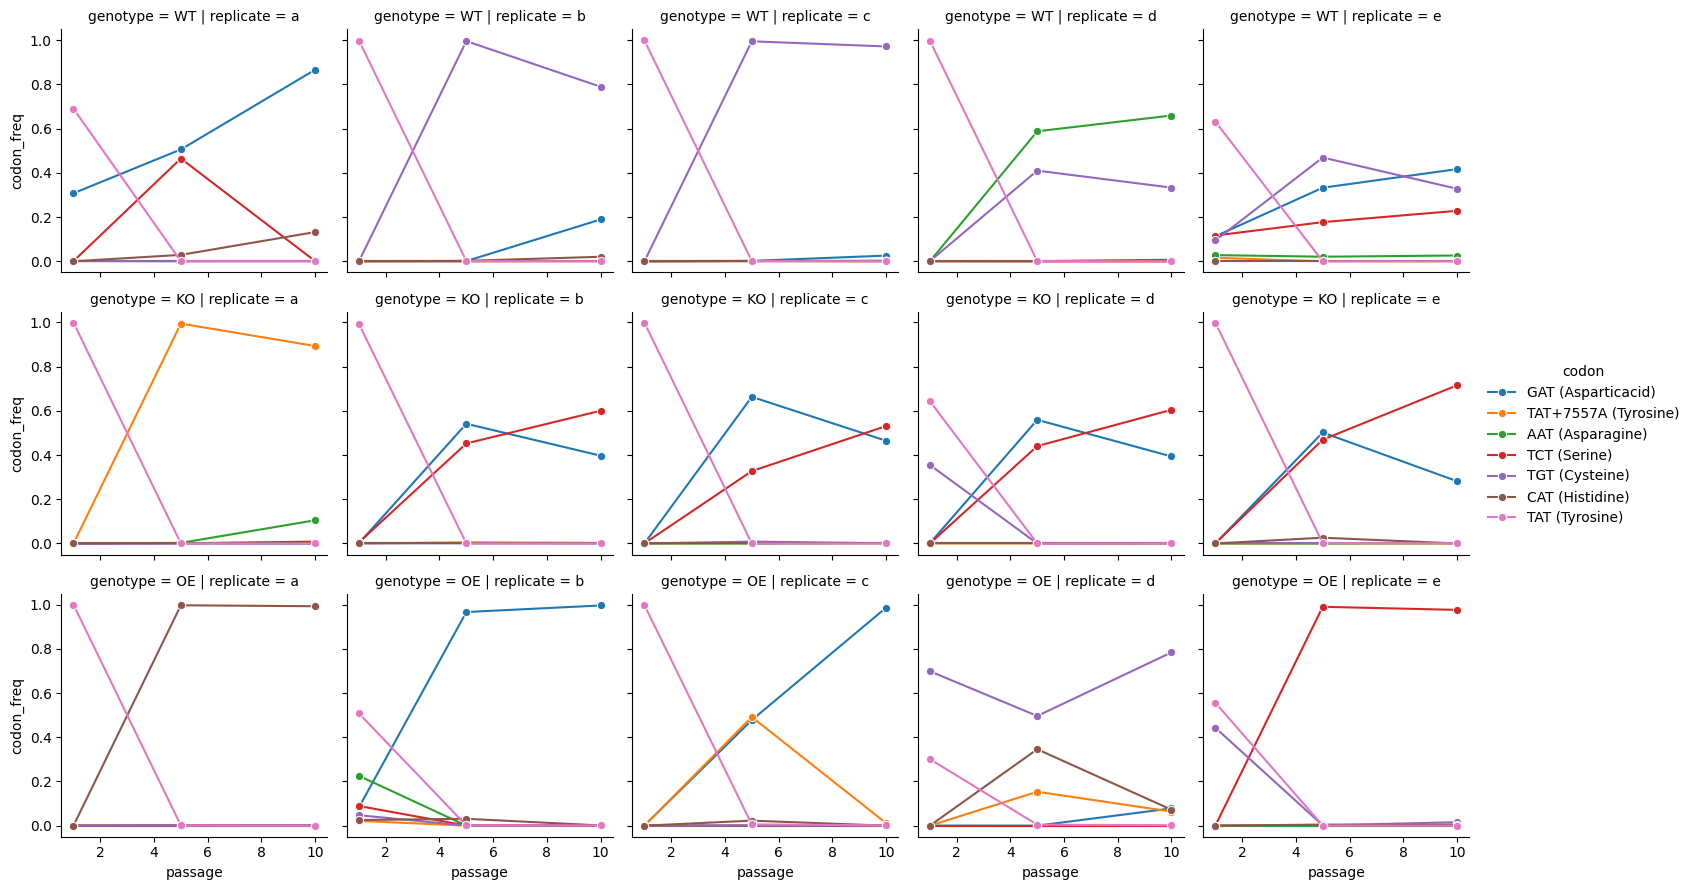

In [18]:
# plot the trajectories

g = sns.FacetGrid(df_red_re, 
                  col="replicate", 
                  hue="codon", 
                  row='genotype',
                  row_order=['WT', 'KO', 'OE'])
g.map_dataframe(sns.lineplot, x="passage", y="codon_freq", marker='o')
g.add_legend()

In [19]:
g.figure.savefig("./000__Manuscript_figures/Figure_5A__capsid_cooccurring_muts.pdf")
g.figure.savefig("./000__Manuscript_figures/Figure_5A__capsid_cooccurring_muts.svg")

In [16]:
df_red_re[(df_red_re['genotype']=='KO') & (df_red_re['replicate']=='a') & (df_red_re['passage']==10) ]

,genotype,replicate,passage,codon,codon_freq
6,KO,a,10,TAT+7557A (Tyrosine),0.89337
7,KO,a,10,AAT (Asparagine),0.10499
8,KO,a,10,TCT (Serine),0.00839
162,KO,a,10,CAT (Histidine),0.00000
163,KO,a,10,GAT (Asparticacid),0.00000
164,KO,a,10,TGT (Cysteine),0.00000
165,KO,a,10,TAT (Tyrosine),0.00000


In [17]:
df_red_re[(df_red_re['genotype']=='OE') & (df_red_re['replicate']=='d') & (df_red_re['passage']==10) ]

,genotype,replicate,passage,codon,codon_freq
86,OE,d,10,TAT+7557A (Tyrosine),0.06363
87,OE,d,10,CAT (Histidine),0.07220
88,OE,d,10,GAT (Asparticacid),0.07812
89,OE,d,10,TGT (Cysteine),0.78397
250,OE,d,10,AAT (Asparagine),0.00000
251,OE,d,10,TCT (Serine),0.00000
252,OE,d,10,TAT (Tyrosine),0.00208
